In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt # type: ignore
import numpy as np
import polars as pl

In [3]:
from dspy.hdb import get_dataset

In [24]:
RCS = [f"{coin}USDT" for coin in ["BTC", "ETH", "SOL", "DOGE", "LINK"]]
TIMES = ['250120.000100', '250120.215000']

# <font color="grey">Data loading and handling</font>

Data is available in two forms: limit order book (LOB) and trade data. The timestamps are given in nanosecond resolution as Unix timestamps, but the granularity of the data is not that fine. A simple dataloader and some helper function to convert Python datetime objects or strings of the form '240802.1450' into timestamps are provided. The 'book' data contains best bid and ask prices with corresponding volumes. The 'trade' data contains trades, with a signed quantity representing direction. There is also an associated trade id in order to identify individual trades.

In [5]:
dl = get_dataset("terank")

####  <a id='chapter1'> <font color="grey">1. Book</font></a>

In [19]:
df = dl.load_book(RCS[0:2], TIMES, lazy=True)
# Add human readable timestamp and mid prices
df = df.ds.add_datetime('ts').feature.add_mid(products=RCS[0:2])

In [20]:
# This takes some time, not because of the loading but because of the aggregation
df = df.collect()
df.head()

ts,prc_s0_BTCUSDT,prc_s1_BTCUSDT,vol_s0_BTCUSDT,vol_s1_BTCUSDT,prc_s0_ETHUSDT,prc_s1_ETHUSDT,vol_s0_ETHUSDT,vol_s1_ETHUSDT,dts,mid_BTCUSDT,mid_ETHUSDT
i64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],f64,f64
1735725600012000000,93382.0,93382.1,11.471,1.673,3333.63,3333.64,93.753,0.555,2025-01-01 10:00:00.012,93382.05,3333.635
1735725600015000000,93382.0,93382.1,11.413,1.393,3333.63,3333.64,93.753,0.555,2025-01-01 10:00:00.015,93382.05,3333.635
1735725600061000000,93382.0,93382.1,11.413,1.393,3333.63,3333.64,93.782,0.555,2025-01-01 10:00:00.061,93382.05,3333.635
1735725600070000000,93382.0,93382.1,11.413,1.393,3333.63,3333.64,93.806,0.555,2025-01-01 10:00:00.070,93382.05,3333.635
1735725600075000000,93382.0,93382.1,11.355,1.393,3333.63,3333.64,93.806,0.555,2025-01-01 10:00:00.075,93382.05,3333.635


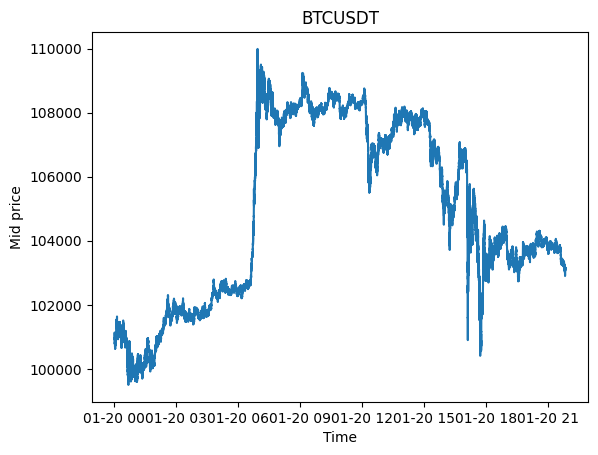

In [8]:
plt.plot(df['dts'], df[f'mid_{RCS[0]}'])
plt.xlabel('Time')
plt.ylabel('Mid price')
plt.title(f'{RCS[0]}')
plt.show()

In [21]:
# Add a column with random +1 or -1 entries
df = df.with_columns(
    pl.lit(np.random.choice([1., -1.], size=len(df))).alias('random_signal')
)

In [31]:
pdf = df.target.add_sig_pnl(ts_col="ts", col="mid_ETHUSDT", signal="random_signal", horizon="1m", in_bp=False)
pdf.head()

ts,prc_s0_BTCUSDT,prc_s1_BTCUSDT,vol_s0_BTCUSDT,vol_s1_BTCUSDT,prc_s0_ETHUSDT,prc_s1_ETHUSDT,vol_s0_ETHUSDT,vol_s1_ETHUSDT,dts,mid_BTCUSDT,mid_ETHUSDT,random_signal,pnl_sig_1m
i64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],f64,f64,f64,f64
1735725600012000000,93382.0,93382.1,11.471,1.673,3333.63,3333.64,93.753,0.555,2025-01-01 10:00:00.012,93382.05,3333.635,1.0,-1.57
1735725600015000000,93382.0,93382.1,11.413,1.393,3333.63,3333.64,93.753,0.555,2025-01-01 10:00:00.015,93382.05,3333.635,-1.0,1.57
1735725600061000000,93382.0,93382.1,11.413,1.393,3333.63,3333.64,93.782,0.555,2025-01-01 10:00:00.061,93382.05,3333.635,-1.0,1.57
1735725600070000000,93382.0,93382.1,11.413,1.393,3333.63,3333.64,93.806,0.555,2025-01-01 10:00:00.070,93382.05,3333.635,1.0,-1.57
1735725600075000000,93382.0,93382.1,11.355,1.393,3333.63,3333.64,93.806,0.555,2025-01-01 10:00:00.075,93382.05,3333.635,1.0,-1.57


####  <a id='chapter2'> <font color="grey">2. Trades</font></a>

In [25]:
products = ['BTCUSDT', 'ETHUSDT']

In [26]:
tdf = dl.load_trades(products, TIMES, lazy=True)
# By default, the timestamp column is named 'ts'
tdf = tdf.trade.agg_trades().trade.add_side().ds.add_datetime()

In [27]:
tdf = tdf.collect()
tdf.head()

ts,prc,product,trade_id,qty,side,dts
i64,f64,str,i64,f64,i32,datetime[ns]
1737331260005000000,100950.2,"""BTCUSDT""",5861367082,-0.001,-1,2025-01-20 00:01:00.005
1737331260005000000,100949.8,"""BTCUSDT""",5861367083,-0.002,-1,2025-01-20 00:01:00.005
1737331260008000000,100949.8,"""BTCUSDT""",5861367084,-0.019,-1,2025-01-20 00:01:00.008
1737331260008000000,100949.5,"""BTCUSDT""",5861367086,-0.002,-1,2025-01-20 00:01:00.008
1737331260008000000,100948.1,"""BTCUSDT""",5861367087,-0.002,-1,2025-01-20 00:01:00.008


####  <a id='chapter3'> <font color="grey">3. Positions</font></a>

In [14]:
from dspy.features.positions import create_test_positions_data

In [15]:
df = create_test_positions_data()
print(df)

shape: (10, 8)
┌────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬───────────┬────────┐
│ ts         ┆ mid_BTCUSD ┆ mid_ETHUSD ┆ pos_BTCUSD ┆ pos_ETHUSD ┆ pnl_BTCUSD ┆ pnl_ETHUS ┆ pnl    │
│ ---        ┆ T          ┆ T          ┆ T          ┆ T          ┆ T          ┆ DT        ┆ ---    │
│ datetime[μ ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---       ┆ f64    │
│ s]         ┆ f64        ┆ f64        ┆ f64        ┆ f64        ┆ f64        ┆ f64       ┆        │
╞════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪═══════════╪════════╡
│ 2023-01-01 ┆ 100.0      ┆ 50.0       ┆ 1.0        ┆ 0.5        ┆ -0.02      ┆ 0.0       ┆ -0.02  │
│ 00:00:00   ┆            ┆            ┆            ┆            ┆            ┆           ┆        │
│ 2023-01-01 ┆ 101.0      ┆ 50.5       ┆ 0.5        ┆ -0.5       ┆ 0.9699     ┆ 0.25      ┆ 1.2199 │
│ 00:00:01   ┆            ┆            ┆            ┆            ┆          

####  <a id='chapter4'> <font color="grey">4. Fixed-frequency data</font></a>

In [18]:
df = dl.load(products, TIMES, freq="1s")
df.head()

ts,mid_BTCUSDT,mid_ETHUSDT
datetime[ns],f64,f64
2025-01-01 10:00:01,93382.05,3333.445
2025-01-01 10:00:02,93382.05,3333.445
2025-01-01 10:00:03,93382.05,3333.065
2025-01-01 10:00:04,93382.05,3333.045
2025-01-01 10:00:05,93387.75,3333.355


####  <a id='chapter5'> <font color="grey">5. Signals</font></a>